In [1]:
# %% # Imports
# -*- coding: utf-8 -*-
"""
This script analyzes neural and behavioral data in a multi-area calcium imaging
dataset with labeled projection neurons. The visual stimuli are natural images.
Matthijs Oude Lohuis, 2023, Champalimaud Center
Anastasia Simonoff, 2024, Bernstein Center for Computational Neuroscience Berlin
"""

# Import general libs
import logging
from sklearn.preprocessing import normalize
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn import preprocessing
from tqdm.auto import tqdm

# Set working directory to root of repo
current_path = os.getcwd()
# Identify if path has 'molanalysis' as a folder in it
if 'molanalysis' in current_path:
    # If so, set the path to the root of the repo
    current_path = current_path.split('molanalysis')[0] + 'molanalysis'
elif current_path.split('\\')[-1] == 'Petreanu Lab':
    current_path = current_path + '\molanalysis'
else:
    raise FileNotFoundError(
        f'This needs to be run from within the molanalysis folder, not {current_path}')
os.chdir(current_path)

# Set up logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(pathname)s - %(message)s', handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# Create a StreamHandler
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)  # Set the logging level for the handler
# Create a Formatter and attach it to the handler
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(pathname)s - %(message)s')
console_handler.setFormatter(formatter)
# Add the handler to the logger
logger.addHandler(console_handler)

logger.info('Current working directory: %s', current_path)

# TODO: Fix this so it outputs correctly during figure generation
rmap_logger = logging.getLogger('rastermap')
rmap_logger.setLevel(logging.WARNING)
rmap_logger.addHandler(console_handler)
rmap_logger.propagate = False

2024-09-30 11:50:42,446 - __main__ - INFO - C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_61964\2629618833.py - Current working directory: d:\Python\Anastasia\Petreanu Lab\molanalysis
2024-09-30 11:50:42,446 - __main__ - INFO - C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_61964\2629618833.py - Current working directory: d:\Python\Anastasia\Petreanu Lab\molanalysis


In [2]:
# %% # Import personal lib funcs
from loaddata.session_info import filter_sessions, load_sessions
from utils.plotting_style import *  # get all the fixed color schemes
from utils.imagelib import load_natural_images
from utils.explorefigs import *
from utils.psth import compute_tensor, compute_respmat, construct_behav_matrix_ts_F
from loaddata.get_data_folder import get_local_drive
from utils.corr_lib import mean_resp_image, compute_signal_correlation, compute_pairwise_metrics


# Updated by Anastasia Simonoff for her local computer, etc.

savedir = os.path.join(get_local_drive(
), 'Users\\asimo\\Documents\\BCCN\\Lab Rotations\\Petreanu Lab\\Figures\\Images' if os.environ['USERDOMAIN'] == 'ULTINTELLIGENCE' else 'OneDrive\\PostDoc\\Figures\\Images\\')
logger.info(f'Saving figures to {savedir}')

2024-09-30 11:50:43,278 - utils.explorefigs - INFO - C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_61964\672048344.py - Saving figures to D:/OneDrive\PostDoc\Figures\Images\


In [3]:
os.getcwd()

'd:\\Python\\Anastasia\\Petreanu Lab\\molanalysis'

In [4]:
# basepath = "../sensorium/notebooks/data/IM_prezipped"
basepath = "data/IM"
# Add Add folders two levels deep from basepath into a list
# First level
folders = [os.path.join(basepath, name) for name in os.listdir(
    basepath) if os.path.isdir(os.path.join(basepath, name)) and not "merged_data" in name]
folders = [x.replace("\\", "/") for x in folders]
# Second level
files = [[folder, os.path.join(folder, name).replace('\\', '/')] for folder in folders for name in os.listdir(
    folder) if os.path.isdir(os.path.join(folder, name)) and not "merged_data" in name]
# only get last value after /
session_list = [[folder.split("/")[-1], name.split("/")[-1]]
                for folder, name in files]

# drop ['LPE10919', '2023_11_08'] because the data is not converted yet
session_list = [x for x in session_list if x != ['LPE10919', '2023_11_08']]
session_list

[['LPE09665', '2023_03_15'],
 ['LPE09665', '2023_03_20'],
 ['LPE10883', '2023_10_23'],
 ['LPE10883', '2023_10_31'],
 ['LPE10884', '2023_10_12'],
 ['LPE10885', '2023_10_20'],
 ['LPE10919', '2023_11_09'],
 ['LPE11086', '2023_12_16'],
 ['LPE11086', '2024_01_09'],
 ['LPE11495', '2024_02_29'],
 ['LPE11622', '2024_03_27'],
 ['LPE11998', '2024_05_08'],
 ['LPE12223', '2024_06_11']]

In [5]:
# %% Load one session including raw data: ################################################
# example session with good responses
# session_list = np.array([['LPE10885', '2023_10_20']])
# session_list = np.array(session_list)
# folders = [os.path.join(basepath, 'LPE10885')]
# files = [[folder, os.path.join(folder, '2023_10_20')]
#          for folder in folders]

# Load sessions lazy: (no calciumdata, behaviordata etc.,)
sessions, nSessions = load_sessions(protocol='IM', session_list=np.array(session_list))

# Load proper data and compute average trial responses:
for ises in tqdm(range(nSessions)):    # iterate over sessions
    sessions[ises].load_respmat(calciumversion='deconv', keepraw=True)

    # Save respmat
    np.save(os.path.join(files[ises][1], 'respmat.npy'), sessions[ises].respmat)

2024-09-30 11:50:43,564 - loaddata.session_info - INFO - d:\Python\Anastasia\Petreanu Lab\molanalysis\loaddata\session_info.py - ['IM'] dataset: 10 mice, 13 sessions, 72800 trials
2024-09-30 11:50:43,580 - loaddata.session_info - INFO - d:\Python\Anastasia\Petreanu Lab\molanalysis\loaddata\session_info.py - Number of neurons in PM: 14680
2024-09-30 11:50:43,580 - loaddata.session_info - INFO - d:\Python\Anastasia\Petreanu Lab\molanalysis\loaddata\session_info.py - Number of neurons in V1: 19324
2024-09-30 11:50:43,580 - loaddata.session_info - INFO - d:\Python\Anastasia\Petreanu Lab\molanalysis\loaddata\session_info.py - Total number of neurons: 34004


  0%|          | 0/13 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE09665\2023_03_15\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

d:\Python\Anastasia\Petreanu Lab\molanalysis\loaddata\session.py:246: RuntimeWarning: Mean of empty slice
  arr[i] = np.nanmean([arr[i - 1], arr[i + 1]])


Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE09665\2023_03_20\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE10883\2023_10_23\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE10883\2023_10_31\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE10884\2023_10_12\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE10885\2023_10_20\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE10919\2023_11_09\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE11086\2023_12_16\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE11086\2024_01_09\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE11495\2024_02_29\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE11622\2024_03_27\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

d:\Python\Anastasia\Petreanu Lab\molanalysis\loaddata\session.py:246: RuntimeWarning: Mean of empty slice
  arr[i] = np.nanmean([arr[i - 1], arr[i + 1]])


Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE11998\2024_05_08\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

Loading calcium data at D:\Python\Anastasia\Petreanu Lab\molanalysis\data\IM\LPE12223\2024_06_11\deconvdata.csv


Computing average response for response matrix:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for runspeed:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for motion energy:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil x position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil y position:   0%|          | 0/5600 [00:00<?, ?it/s]

Computing average response for pupil area:   0%|          | 0/5600 [00:00<?, ?it/s]

In [6]:

# #%% Load all IM sessions including raw data: ################################################
# sessions,nSessions   = filter_sessions(protocols = ['IM'])
# for ises in range(nSessions):    # iterate over sessions
#     sessions[ises].load_respmat(calciumversion='deconv',keepraw=False)

In [7]:
def replace_nan_with_avg(arr):
    arr = arr.copy()  # Copy the array to avoid modifying the original
    nan_indices = np.where(np.isnan(arr))[0]  # Get indices of NaN values

    for i in nan_indices:
        # Handle cases where NaN is at the start or end of the array
        if i == 0:
            arr[i] = arr[i + 1]
        elif i == len(arr) - 1:
            arr[i] = arr[i - 1]
        else:
            # Replace NaN with the average of adjacent values
            arr[i] = np.nanmean([arr[i - 1], arr[i + 1]])

    return arr

In [8]:
import shutil 
# Save behavior data in sensorium format

for i, (sess, sess_obj) in enumerate(zip(session_list, sessions)):
    folder_base = f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/{sess[1]}'

    pupil_size = sess_obj.respmat_pupilarea.reshape(-1, 1)
    change_of_pupil_size = sess_obj.respmat_pupilareaderiv.reshape(-1, 1)
    locotomion_speed = sess_obj.respmat_runspeed.reshape(-1, 1)

    # Data
    folder = f'{folder_base}/data/behavior'
    os.makedirs(folder, exist_ok=True)

    if np.isnan(pupil_size).all() or np.isnan(change_of_pupil_size).all() or np.isnan(locotomion_speed).all():
        logger.warning(
            f'All values in behavior data for session {sess[0]}/{sess[1]} are NaN. Removing session from list.')
        # Drop session from list
        session_list = np.delete(session_list, i, axis=0)
        sessions = np.delete(sessions, i, axis=0)
        # Remove folder
        shutil.rmtree(folder_base)
        try:
            os.rmdir(folder_base)
            os.rmdir(f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/')
        except FileNotFoundError:
            pass
        continue

    behavior = np.hstack((pupil_size, change_of_pupil_size, locotomion_speed))
    behavior = replace_nan_with_avg(behavior)
    assert not np.isnan(behavior).any(), 'There are still NaN values in the behavior data'

    for i in tqdm(range(behavior.shape[0])):
        np.save(f'{folder}/{i}.npy', behavior[i, :])

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/behavior/all'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(behavior, axis=0)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(behavior, axis=0)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(behavior, axis=0)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(behavior, axis=0)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(behavior, axis=0)
    np.save(f'{folder}/median.npy', median)

    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/behavior/stimulus_Frame'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(behavior, axis=0)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(behavior, axis=0)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(behavior, axis=0)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(behavior, axis=0)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(behavior, axis=0)
    np.save(f'{folder}/median.npy', median)

2024-09-30 11:53:52,352 - utils.explorefigs - WARNING - C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_61964\2870189059.py - All values in behavior data for session LPE09665/2023_03_15 are NaN. Removing session from list.


  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

2024-09-30 11:54:01,170 - utils.explorefigs - WARNING - C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_61964\2870189059.py - All values in behavior data for session LPE11622/2024_03_27 are NaN. Removing session from list.


  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

In [9]:
# %% ### Load the natural images:
# natimgdata = load_natural_images(onlyright=True)
natimgdata = load_natural_images()
natimgdata = natimgdata[:, natimgdata.shape[1]//2:, :]  # Only take the right half

In [10]:
# Save natimgdata in sensorium format

for sess, sess_obj in zip(session_list, sessions):
    folder_base = f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/{sess[1]}'

    folder = f'{folder_base}/data/images'
    os.makedirs(folder, exist_ok=True)

    image_idxs = sess_obj.trialdata['ImageNumber'].values

    for i, imgidx in tqdm(enumerate(image_idxs), total=len(image_idxs)):
        file_name = f'{folder}/{i}.npy'
        img = natimgdata[:, :, imgidx]
        img = np.reshape(img, (-1, img.shape[0], img.shape[1]))
        np.save(file_name, img)  # hacky but works

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/images/all'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(natimgdata)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(natimgdata)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(natimgdata)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(natimgdata)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(natimgdata)
    np.save(f'{folder}/median.npy', median)

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/images/stimulus_Frame'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(natimgdata)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(natimgdata)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(natimgdata)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(natimgdata)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(natimgdata)
    np.save(f'{folder}/median.npy', median)

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

In [11]:
# Save pupil center data in sensorium format

for sess, sess_obj in zip(session_list, sessions):
    folder_base = f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/{sess[1]}'
    folder = f'{folder_base}/data/pupil_center'
    os.makedirs(folder, exist_ok=True)
    pupil_x = sess_obj.respmat_pupilx.reshape(-1, 1)
    pupil_y = sess_obj.respmat_pupily.reshape(-1, 1)

    pupil_center = np.hstack((pupil_x, pupil_y))
    pupil_center = replace_nan_with_avg(pupil_center)

    while np.isnan(pupil_center).any():
        pupil_center = replace_nan_with_avg(pupil_center)

    for i in tqdm(range(pupil_center.shape[0])):
        np.save(f'{folder}/{i}.npy', pupil_center[i, :])

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/pupil_center/all'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(pupil_center, axis=0)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(pupil_center, axis=0)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(pupil_center, axis=0)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(pupil_center, axis=0)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(pupil_center, axis=0)
    np.save(f'{folder}/median.npy', median)

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/pupil_center/stimulus_Frame'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(pupil_center, axis=0)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(pupil_center, axis=0)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(pupil_center, axis=0)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(pupil_center, axis=0)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(pupil_center, axis=0)
    np.save(f'{folder}/median.npy', median)

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

C:\Users\Kerem Sarikaya\AppData\Local\Temp\ipykernel_61964\3146663683.py:13: RuntimeWarning: Mean of empty slice
  arr[i] = np.nanmean([arr[i - 1], arr[i + 1]])


  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

In [ ]:
layer_of_interest = 'V1'

# Add neuron data

for sess, sess_obj in zip(session_list, sessions):
    folder_base = f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/{sess[1]}'
    folder = f'{folder_base}/meta/neurons'
    os.makedirs(folder, exist_ok=True)

    celldata = sess_obj.celldata.copy()

    # layer
    # V1
    celldata.loc[(celldata['roi_name'] == 'V1') & (
        celldata['depth'] < 250), 'layer'] = 'L2/3'
    celldata.loc[(celldata['roi_name'] == 'V1') & (
        celldata['depth'] >= 250) & (celldata['depth'] < 350), 'layer'] = 'L4'
    celldata.loc[(celldata['roi_name'] == 'V1') & (
        celldata['depth'] >= 350), 'layer'] = 'L5/6'

    # PM
    celldata.loc[(celldata['roi_name'] == 'PM') & (
        celldata['depth'] < 250), 'layer'] = 'L2/3'
    celldata.loc[(celldata['roi_name'] == 'PM') & (
        celldata['depth'] >= 250) & (celldata['depth'] < 325), 'layer'] = 'L4'
    celldata.loc[(celldata['roi_name'] == 'PM') & (
        celldata['depth'] >= 325), 'layer'] = 'L5'
    
    celldata = celldata.loc[celldata['roi_name'] == layer_of_interest]
    
    # Save celldata to obj
    sess_obj.celldata = celldata.copy()

    num_neurons = len(celldata)
    
    # layer
    np.save(f'{folder}/layer.npy',
            celldata['layer'].to_numpy(dtype='<U32'))
    
    # animal ids
    np.save(f'{folder}/animal_ids.npy',
            np.full((num_neurons, ), sess_obj.animal_id, dtype='<U32'))

    # area
    np.save(f'{folder}/area.npy',
            celldata['roi_name'].to_numpy(dtype='<U32'))

    # cell motor coordinates
    np.save(f'{folder}/cell_motor_coordinates.npy',
            celldata[['xloc', 'yloc', 'depth']].to_numpy(dtype=int))

    # scan idx
    np.save(f'{folder}/scan_idx.npy',
            np.full((num_neurons, ), 0))

    # sessions
    np.save(f'{folder}/sessions.npy',
            celldata['session_id'].to_numpy(dtype='<U32'))

    # unit ids
    np.save(f'{folder}/unit_ids.npy',
            celldata['cell_id'].to_numpy(dtype='<U32'))

In [12]:
# Save responses in sensorium format

for sess, sess_obj in zip(session_list, sessions):
    folder_base = f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/{sess[1]}'
    folder = f'{folder_base}/data/responses'
    os.makedirs(folder, exist_ok=True)

    responses = sess_obj.respmat
    responses = replace_nan_with_avg(responses)

    celldata = sess_obj.celldata.copy()

    responses = responses[celldata.index.values]

    sess_obj.respmat = responses

    for i in tqdm(range(responses.shape[1])):
        np.save(f'{folder}/{i}.npy', responses[:, i])

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/responses/all'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(responses, axis=1)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(responses, axis=1)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(responses, axis=1)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(responses, axis=1)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(responses, axis=1)
    np.save(f'{folder}/median.npy', median)

    # Meta
    # There is also a /stimulus_Frame, but I'm not sure what the difference is
    folder = f'{folder_base}/meta/statistics/responses/stimulus_Frame'
    os.makedirs(folder, exist_ok=True)

    # Mean
    mean = np.mean(responses, axis=1)
    np.save(f'{folder}/mean.npy', mean)

    # Std
    std = np.std(responses, axis=1)
    np.save(f'{folder}/std.npy', std)

    # Min
    min = np.min(responses, axis=1)
    np.save(f'{folder}/min.npy', min)

    # Max
    max = np.max(responses, axis=1)
    np.save(f'{folder}/max.npy', max)

    # Median
    median = np.median(responses, axis=1)
    np.save(f'{folder}/median.npy', median)

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

  0%|          | 0/5600 [00:00<?, ?it/s]

In [13]:
def calculate_tiers(num_images):
    # Split into train/test/validate
    idxs = np.arange(num_images)
    np.random.shuffle(idxs)
    train_idxs = idxs[:int(num_images * 0.75)]
    test_idxs = idxs[int(num_images * 0.75):int(num_images * 0.916)]
    validate_idxs = idxs[int(num_images * 0.916):]
    return train_idxs, test_idxs, validate_idxs

# Add trial data


for sess, sess_obj in zip(session_list, sessions):
    folder_base = f'../sensorium/notebooks/data/IM_prezipped/{sess[0]}/{sess[1]}'
    folder = f'{folder_base}/meta/trials'
    os.makedirs(folder, exist_ok=True)

    trial_data = sess_obj.trialdata.copy()
    num_trials = trial_data.shape[0]

    # album
    # ???
    np.save(f'{folder}/album.npy',
            np.full((num_trials,), 'UNK', dtype='<U32'))

    # animal id
    np.save(f'{folder}/animal_id.npy',
            np.full((num_trials,), sess_obj.animal_id, dtype='<U32'))

    # condition hash
    # ???
    np.save(f'{folder}/condition_hash.npy',
            np.full((num_trials,), 'UNK', dtype='<U32'))

    # frame image class
    # ???
    np.save(f'{folder}/frame_image_class.npy',
            np.full((num_trials,), 'UNK', dtype='<U32'))

    # frame image id
    np.save(f'{folder}/frame_image_id.npy', trial_data['ImageNumber'].values)

    # frame last flip
    # ???
    np.save(f'{folder}/frame_last_flip.npy',
            np.full((num_trials,), 0))

    # frame pre blank period
    trial_data['tOnset'] = pd.to_datetime(trial_data['tOnset'], unit='s')
    trial_data['tOffset'] = pd.to_datetime(trial_data['tOffset'], unit='s')
    trial_data['presentationTime'] = trial_data['tOffset'] - \
        trial_data['tOnset']

    # calculate inter image interval
    trial_data['tOffset_prev'] = trial_data['tOffset'].shift(1)
    trial_data['tIntertrial'] = trial_data['tOnset'] - \
        trial_data['tOffset_prev']
    trial_data['tIntertrial'].fillna(pd.Timedelta(seconds=0.5), inplace=True)
    trial_data['tIntertrial'] = trial_data['tIntertrial'].dt.total_seconds()
    np.save(f'{folder}/frame_pre_blank_period.npy',
            trial_data['tIntertrial'].values)

    # frame presentation time
    np.save(f'{folder}/frame_presentation_time.npy',
            trial_data['presentationTime'].dt.total_seconds())

    # frame_trial_ts
    np.save(f'{folder}/frame_trial_ts.npy', trial_data['tOnset'].apply(
        lambda x: f"Timestamp('{x}')").to_numpy(dtype='<U32'))

    # scan_idx
    # ???
    np.save(f'{folder}/scan_idx.npy',
            np.full((num_trials,), 0))

    # session
    np.save(f'{folder}/session.npy',
            np.full((num_trials,), sess_obj.session_id))

    # tiers
    trial_data['ImageCount'] = trial_data['ImageNumber'].map(
        trial_data['ImageNumber'].value_counts())
    trial_data['ImagePresentation'] = trial_data.groupby(
        'ImageNumber').cumcount() + 1

    # Assign tiers to images
    for i, group in trial_data.groupby('ImageCount'):
        for j, group2 in group.groupby('ImagePresentation'):
            train_idxs, test_idxs, validate_idxs = calculate_tiers(
                group2.shape[0])

            # Update indices
            train_idxs = group2.index[train_idxs]
            test_idxs = group2.index[test_idxs]
            validate_idxs = group2.index[validate_idxs]

            # assign to tiers
            trial_data.loc[train_idxs, 'tiers'] = 'train'
            trial_data.loc[test_idxs, 'tiers'] = 'test'
            trial_data.loc[validate_idxs, 'tiers'] = 'validation'

    np.save(f'{folder}/tiers.npy',
            trial_data['tiers'].to_numpy(dtype='<U32'))

    # trial_idx
    np.save(f'{folder}/trial_idx.npy', trial_data['TrialNumber'].values)

In [14]:
raise Exception("Stop here")

Exception: Stop here

2024-09-24 22:37:20,985 - utils.explorefigs - INFO - c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\molanalysis\utils\explorefigs.py - Plotting trials 1304 to 1384
2024-09-24 22:37:24,725 - utils.explorefigs - INFO - c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\molanalysis\utils\explorefigs.py - Plotting trials 3294 to 3374
C:\Users\asimo\AppData\Local\Temp\ipykernel_29632\2402861345.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
2024-09-24 22:37:29,204 - utils.explorefigs - INFO - c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\molanalysis\utils\explorefigs.py - Plotting trials 3838 to 3918


normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.07sec
sorting activity: 2651 valid samples by 584 timepoints
n_PCs = 100 computed, 43.75sec
50 clusters computed, time 44.00sec
clusters sorted, time 44.58sec
clusters upsampled, time 44.64sec
rastermap complete, time 44.64sec
normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.00sec
sorting activity: 118 valid samples by 584 timepoints
n_PCs = 100 computed, 0.22sec
50 clusters computed, time 0.25sec


2024-09-24 22:38:14,798 - utils.explorefigs - INFO - c:\Users\asimo\Documents\BCCN\Lab Rotations\Petreanu Lab\molanalysis\utils\explorefigs.py - Plotting trials 3294 to 3374


clusters sorted, time 0.67sec
clusters upsampled, time 0.71sec
rastermap complete, time 0.72sec
normalizing data across axis=1
projecting out mean along axis=0
data normalized, 0.03sec
sorting activity: 2651 valid samples by 588 timepoints


KeyboardInterrupt: 

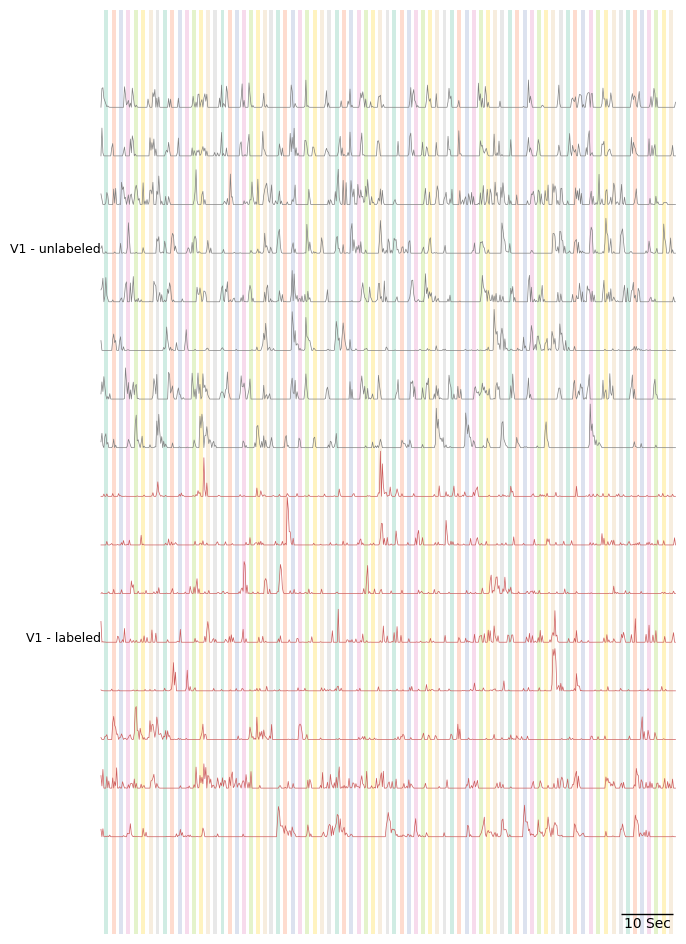

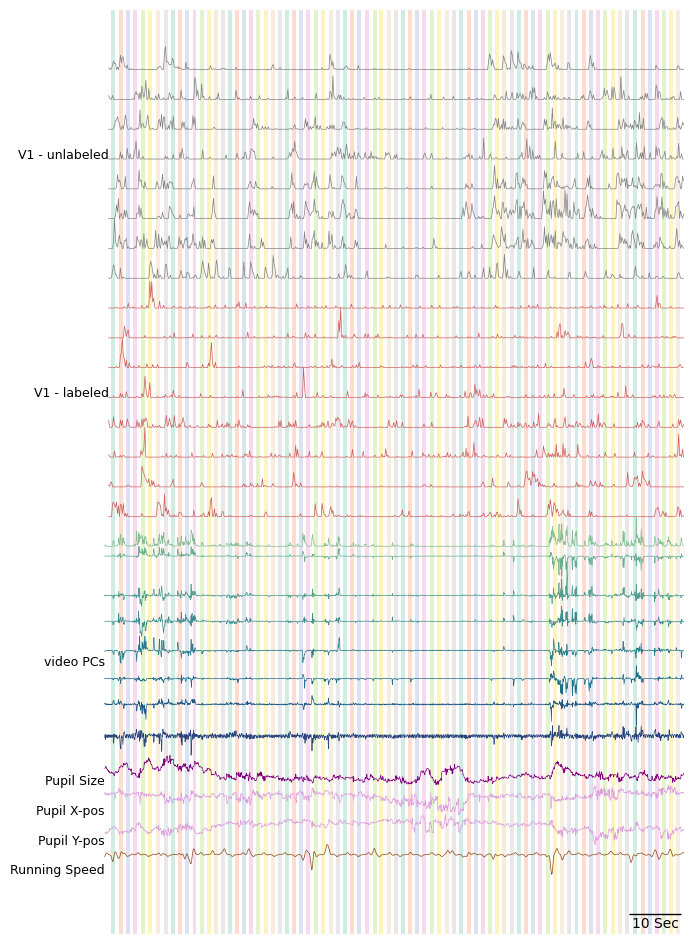

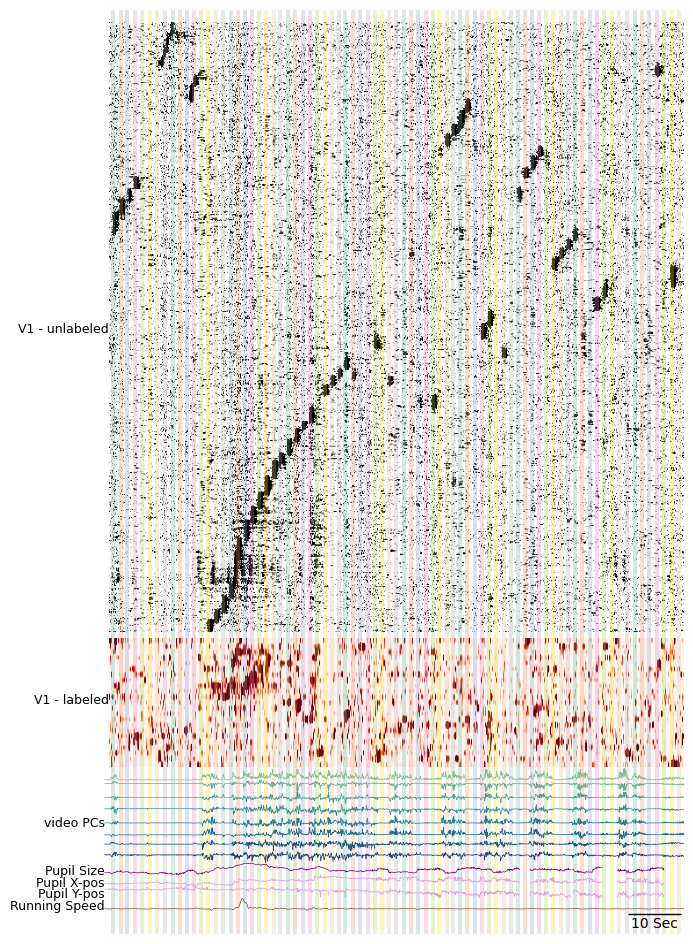

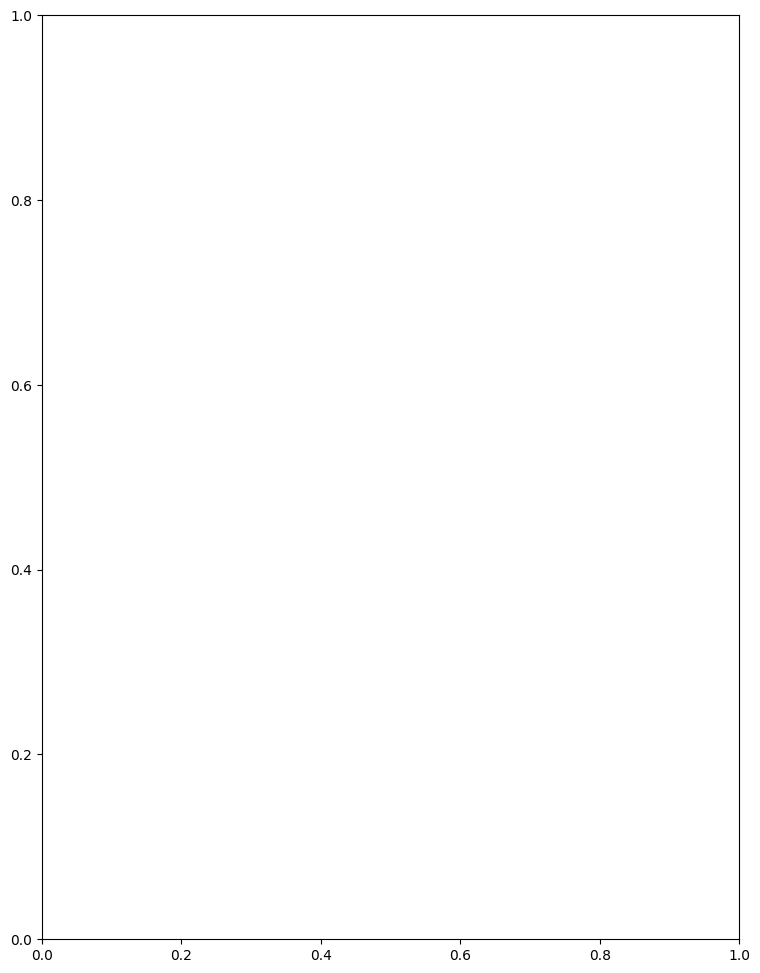

In [ ]:
# %% ###############################################################
# Show some traces and some stimuli to see responses:

sesidx = 0

# Plot random excerpt with traces:
fig = plot_excerpt(sessions[sesidx], trialsel=None,
                   plot_neural=True, plot_behavioral=False)

# plot specific trials with a lot behavior related modulation:
trialsel = [3294, 3374]
fig = plot_excerpt(sessions[sesidx], trialsel=trialsel,
                   plot_neural=True, plot_behavioral=True, neural_version='traces')
# fig.savefig(os.path.join(savedir,'TraceExcerpt_dF_' + sessions[sesidx].sessiondata['session_id'][0] + '.png'), format = 'png')
# fig.savefig(os.path.join(savedir, 'Excerpt_Traces_deconv_' +
#             sessions[sesidx].sessiondata['session_id'][0] + '.png'), format='png')
fig.show()

# Plot random excerpt as a Rastermap (Stringer et al 2023 BioRxiv):

fig = plot_excerpt(sessions[sesidx], trialsel=None, plot_neural=True,
                   plot_behavioral=True, neural_version='raster')
fig = plot_excerpt(sessions[sesidx], trialsel=trialsel,
                   plot_neural=True, plot_behavioral=True, neural_version='raster')
# fig.savefig(os.path.join(savedir, 'Excerpt_Raster_dF_' +
#             sessions[sesidx].sessiondata['session_id'][0] + '.png'), format='png')
fig.show()

c:\Users\asimo\.conda\envs\molanalysis\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
C:\Users\asimo\AppData\Local\Temp\ipykernel_29632\1198828269.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


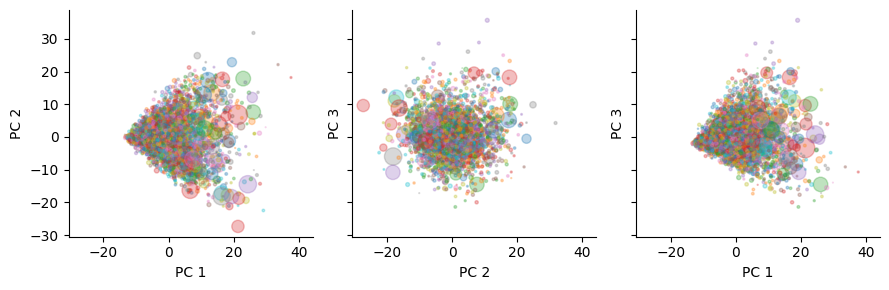

In [ ]:
# %% ########################## Show PCA to get sense of dominant variability ##########################
sesidx = 0

fig = plot_PCA_images(sessions[sesidx])
# fig.savefig(os.path.join(savedir, 'PCA', 'PCA_Gratings_All_' +
#             sessions[sesidx].sessiondata['session_id'][0] + '.png'), format='png')
fig.show()

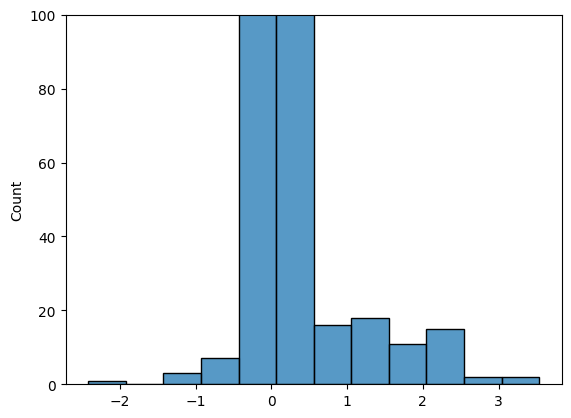

In [ ]:
fig = plt.figure()
sns.histplot(sessions[sesidx].respmat_runspeed, binwidth=0.5)
plt.ylim([0, 100])
plt.show()

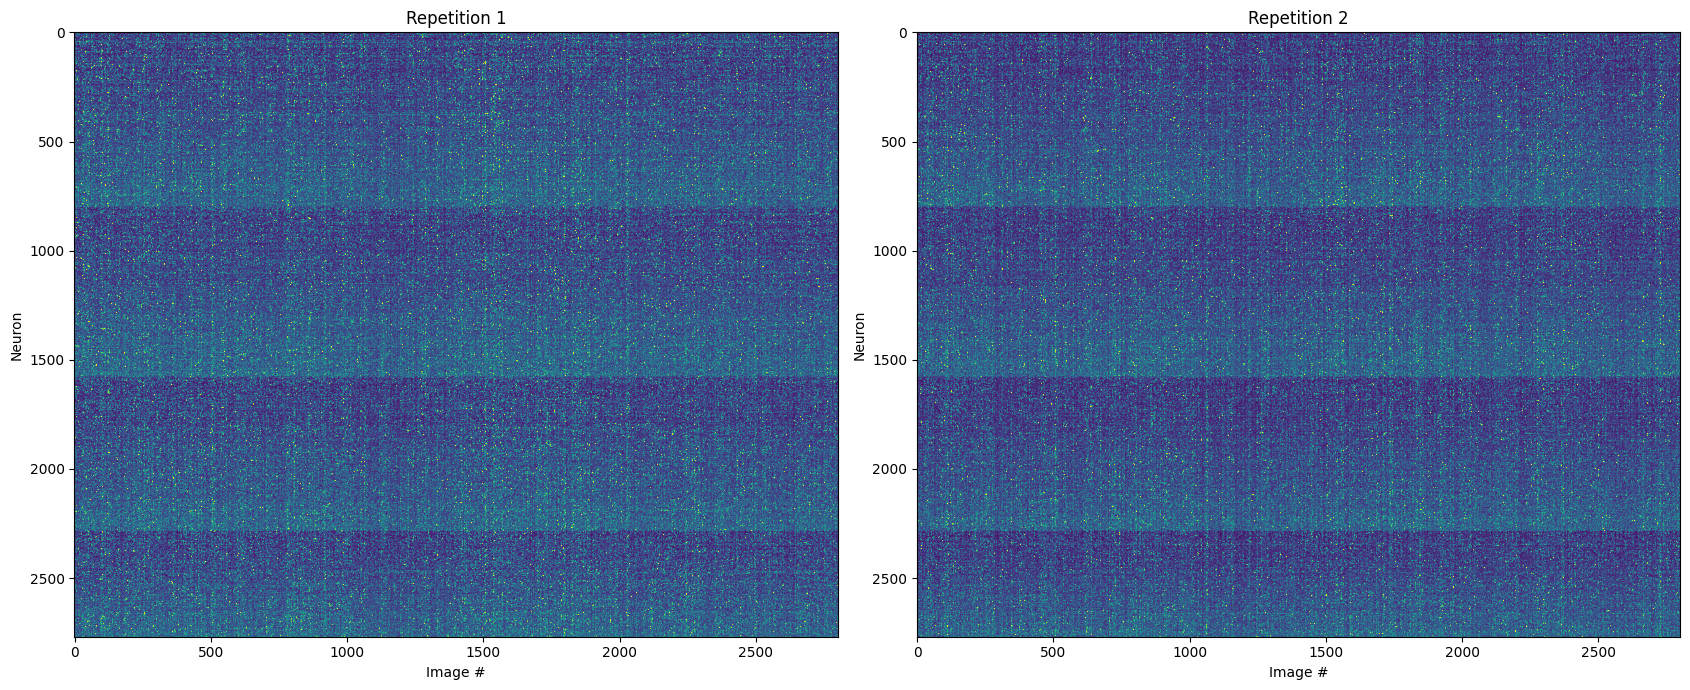

In [ ]:
# %%
sesidx = 0

sessions[sesidx].trialdata['repetition'] = np.r_[
    np.zeros([2800]), np.ones([2800])]

# Sort based on image number:
arr1inds = sessions[sesidx].trialdata['ImageNumber'][:2800].argsort()
arr2inds = sessions[sesidx].trialdata['ImageNumber'][2800:5600].argsort()

respmat = sessions[sesidx].respmat[:, np.r_[arr1inds, arr2inds+2800]]
# respmat_sort = sessions[sesidx].respmat_z[:,np.r_[arr1inds,arr2inds+2800]]


min_max_scaler = preprocessing.MinMaxScaler()
respmat_sort = preprocessing.minmax_scale(
    respmat, feature_range=(0, 1), axis=0, copy=True)

respmat_sort = normalize(respmat, 'l2', axis=1)

fig, axes = plt.subplots(1, 2, figsize=(17, 7))
# fig, axes = plt.subplots(2, 1, figsize=(7, 17))

# axes[0].imshow(respmat_sort[:,:2800], aspect='auto',vmin=-100,vmax=200)
axes[0].imshow(respmat_sort[:, :2800], aspect='auto', vmin=np.percentile(
    respmat_sort, 5), vmax=np.percentile(respmat_sort, 95))
axes[0].set_xlabel('Image #')
axes[0].set_ylabel('Neuron')
axes[0].set_title('Repetition 1')
# axes[1].imshow(respmat_sort[:,2800:], aspect='auto',vmin=-100,vmax=200)
axes[1].imshow(respmat_sort[:, 2800:], aspect='auto', vmin=np.percentile(
    respmat_sort, 5), vmax=np.percentile(respmat_sort, 95))
axes[1].set_xlabel('Image #')
axes[1].set_ylabel('Neuron')
plt.tight_layout(rect=[0, 0, 1, 1])
axes[1].set_title('Repetition 2')
plt.show()

In [ ]:
# %% ##### Show response-triggered frame for cells:
for ises in range(nSessions):
    nImages = len(np.unique(sessions[ises].trialdata['ImageNumber']))
    nNeurons = np.shape(sessions[ises].respmat)[0]
    sessions[ises].respmat_image = np.empty((nNeurons, nImages))
    for iIm in range(nImages):
        sessions[ises].respmat_image[:, iIm] = np.mean(
            sessions[ises].respmat[:, sessions[ises].trialdata['ImageNumber'] == iIm], axis=1)

    # Compute response triggered average image:
    sessions[ises].RTA = np.empty((*np.shape(natimgdata)[:2], nNeurons))

    for iN in tqdm(range(nNeurons), desc='Computing average response for neuron'):
        sessions[ises].RTA[:, :, iN] = np.average(
            natimgdata, axis=2, weights=sessions[ises].respmat_image[iN, :])

Computing average response for neuron:   0%|          | 0/2769 [00:00<?, ?it/s]

KeyboardInterrupt: 

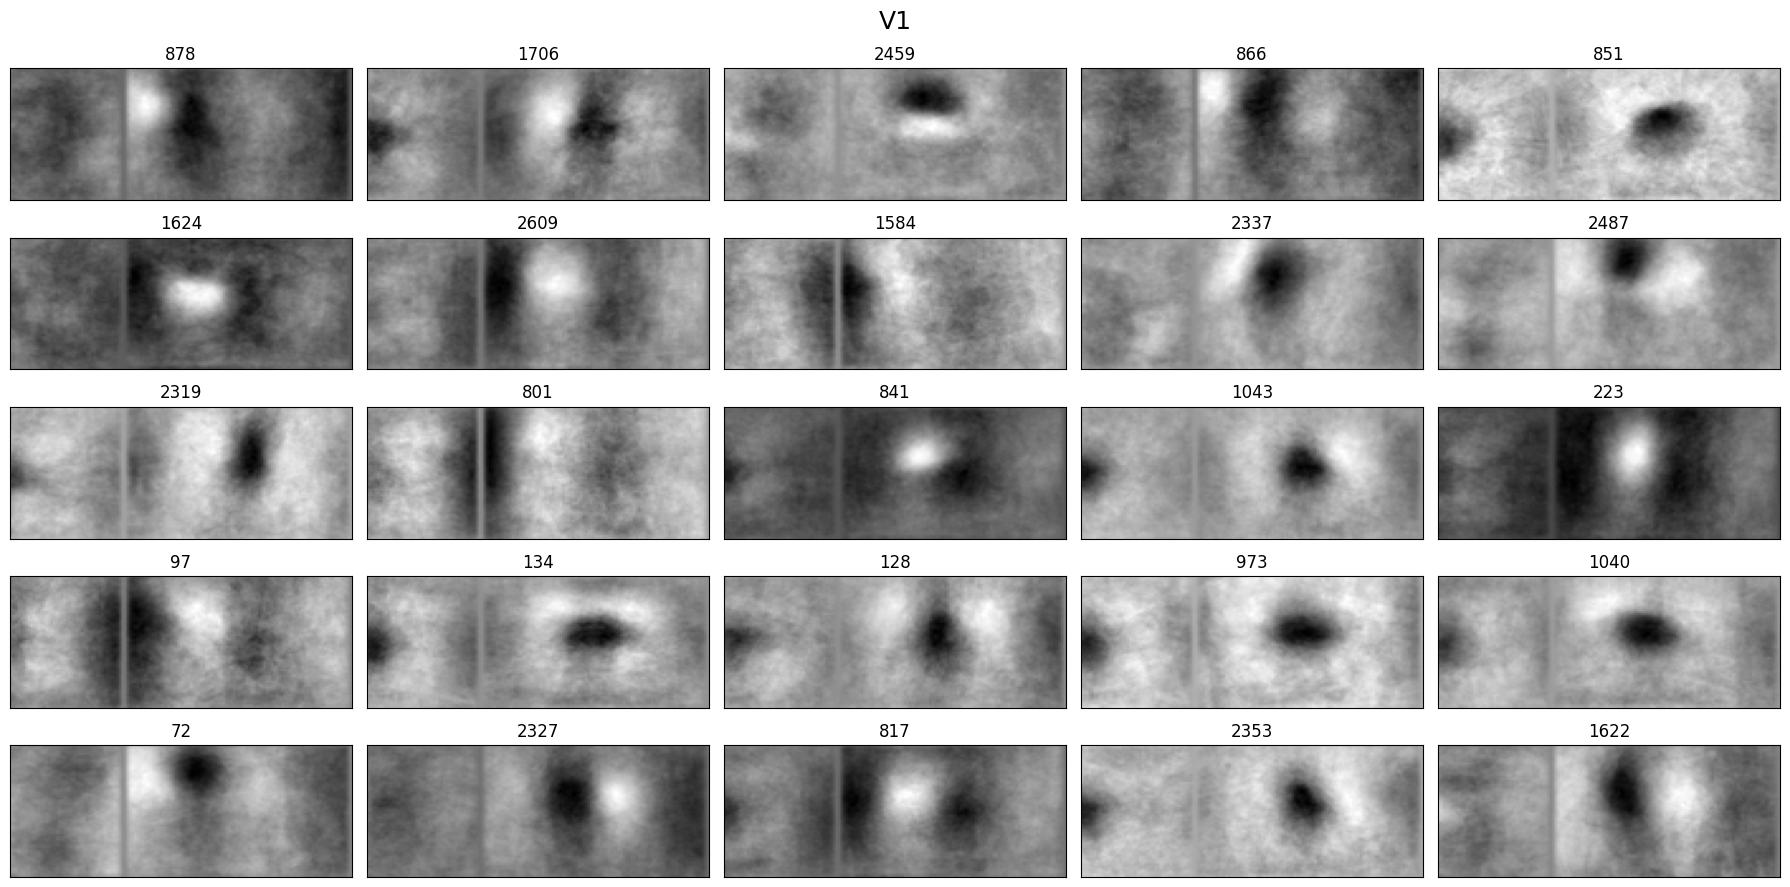

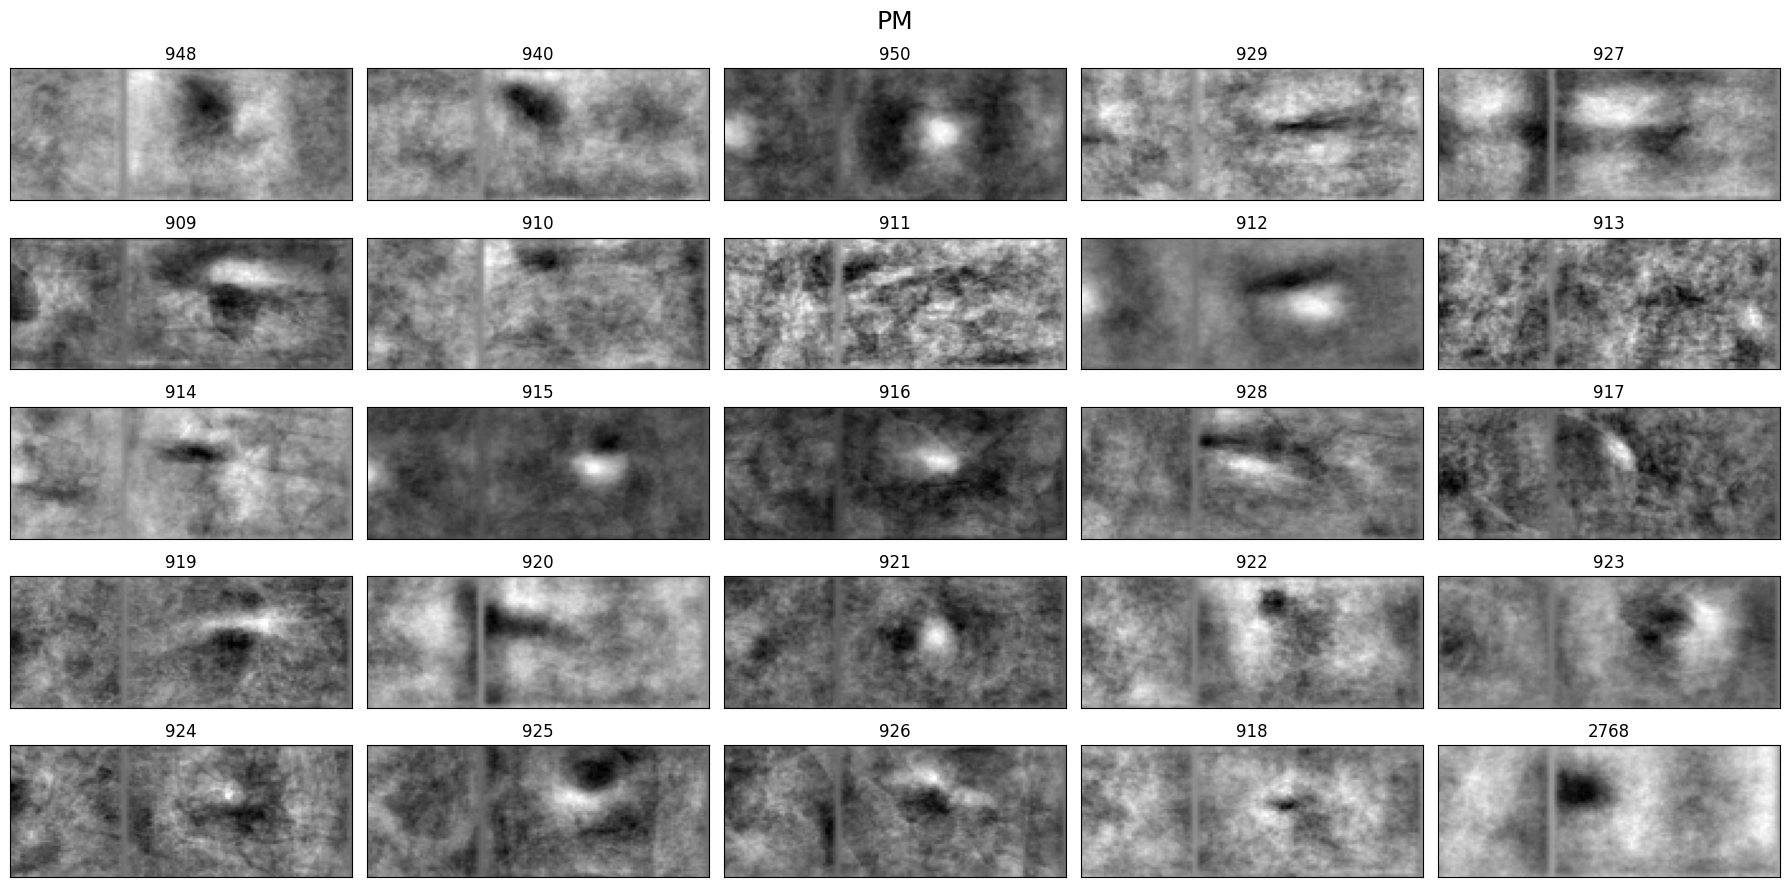

In [ ]:
# %% #### Plot X examples from V1 and PM with high variance in the average image (capturing some consistent preference): ####
ises = 0
RTA_var = np.var(sessions[ises].RTA, axis=(0, 1))

nExamples = 25
areas = ['V1', 'PM']

for area in areas:
    temp = RTA_var.copy()
    temp[sessions[ises].celldata['roi_name'] != area] = 0

    example_cells = np.argsort(temp)[-nExamples:]

    Rows = int(np.floor(np.sqrt(nExamples)))
    Cols = nExamples // Rows  # Compute Rows required
    if nExamples % Rows != 0:  # If one additional row is necessary -> add one:
        Cols += 1
    Position = range(1, nExamples + 1)  # Create a Position index

    fig = plt.figure(figsize=[18, 9])
    for i, n in enumerate(example_cells):
        # add every single subplot to the figure with a for loop
        ax = fig.add_subplot(Rows, Cols, Position[i])
        # ,vmin=100,vmax=150)
        plt.imshow(sessions[ises].RTA[:, :, n], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        ax.set_title("%d" % n)
    plt.suptitle(area, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 1])
    # fig.savefig(os.path.join(savedir,'ResponseTriggeredAverageImage_%s' % area + sessions[sesidx].sessiondata['session_id'][0] + '.png'), format = 'png')

In [ ]:
# %%
####

respmean = mean_resp_image(sessions[sesidx])

In [ ]:
# %%

# We start working from here with convolutional feature maps / deep generative models:

# https://github.com/cajal/inception_loop2019

# https://github.com/sacadena/Cadena2019PlosCB

# https://github.com/dicarlolab/convmap